In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import glob
!pip install rasterio
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Example usage for Confusion Matrix (Replace `y_true` and `y_pred` with actual data)
# y_true = [...]  # Actual labels
# y_pred = [...]  # Predicted labels
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 89.8 MB/s eta 0:00:00


In [ ]:
import os

dataset_path = '/content/drive/MyDrive/2750'

class_image_counts = {}

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        image_count = len(os.listdir(class_folder))
        class_image_counts[class_name] = image_count

import pandas as pd

df = pd.DataFrame(list(class_image_counts.items()), columns=["Class Name", "Number of Images"])
df.sort_values(by="Class Name", inplace=True)

print(df)



             Class Name  Number of Images
2            AnnualCrop              3000
3                Forest              3000
9  HerbaceousVegetation              3000
4               Highway              2500
5            Industrial              2500
0               Pasture              2000
8         PermanentCrop              2500
6           Residential              3000
1                 River              2500
7               SeaLake              3000


In [ ]:
import tensorflow as tf

dataset_url = '/content/drive/MyDrive/2750'
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_data.class_names
print("Class names:", class_names)

for images, labels in train_data.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=validation_split
)

train_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="training",
    class_mode='categorical'
)

test_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation",
    class_mode='categorical'
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


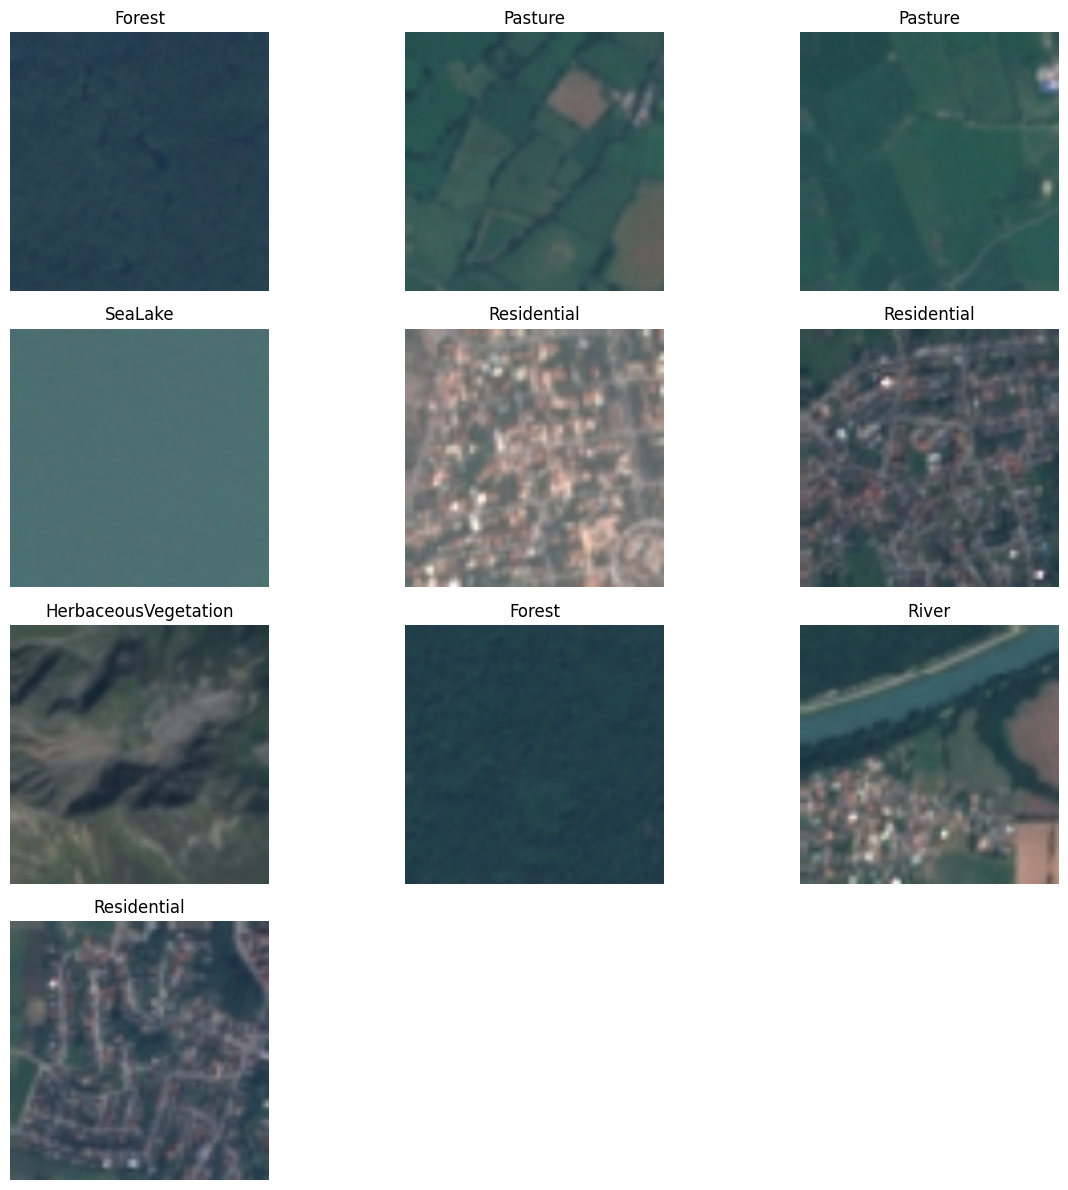

In [ ]:
import matplotlib.pyplot as plt


class_names = train_data.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import RandomUniform

def identity_block(X, f, filters, training=True, initializer=RandomUniform):
    """
    Implementation of the identity block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to RandomUniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Default axis
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X


In [ ]:
import tensorflow as tf


input_tensor = tf.random.normal([1, 224, 224, 3])

# Test the identity block
output_tensor = identity_block(input_tensor, f=3, filters=[64, 64, 3])  # Filters updated to match input channels
print("Output tensor shape:", output_tensor.shape)


Output tensor shape: (1, 224, 224, 3)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import GlorotUniform

def convolutional_block(X, f, filters, s=2, training=True, initializer=GlorotUniform):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- GlorotUniform initializer for weights

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [ ]:
# Test the convolutional block
input_tensor = tf.random.normal([1, 224, 224, 3])  # Example input tensor
output_tensor = convolutional_block(input_tensor, f=3, filters=[64, 64, 256], s=2)
print("Output tensor shape:", output_tensor.shape)


Output tensor shape: (1, 112, 112, 256)


In [ ]:
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

def ResNet50(input_shape=(224, 224, 3), classes=10):
    """
    Implementation of the ResNet-50 architecture.
    """
    # Define the input
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X)

    return model


In [ ]:
from tensorflow.keras.optimizers import SGD

# Create the ResNet-50 model
model = ResNet50(input_shape=(224, 224, 3), classes=10)

# Compile the model with a different optimizer (SGD in this case)
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # SGD with learning rate and momentum
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 112, 112, 64)   │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 64)     │              0 │ activation_6[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 55, 55, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 55, 55, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 55, 55, 64)     │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 55, 55, 64)     │         36,928 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 55, 55, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 55, 55, 64)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 55, 55, 256)    │         16,640 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 55, 55, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 55, 55, 256)    │          1,024 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 55, 55, 256)    │          1,024 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,772,042 (90.68 MB)

 Trainable params: 23,718,922 (90.48 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Confirm batch size
print("Batch size:", train_dataset.batch_size)

# Class indices
print("Class indices:", train_dataset.class_indices)


Batch size: 32
Class indices: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/best_model_scenario_5.keras',  # Use .keras extension
    save_best_only=True,  # Save only if the metric improves
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Save when val_accuracy increases
    verbose=1  # Print a message when saving
)

# Train the model with the callback
history_scenario_1 = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[checkpoint_callback],  # Add the callback here
    verbose=1
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3373 - loss: 4.9810 
Epoch 1: val_accuracy improved from -inf to 0.55167, saving model to /content/drive/My Drive/best_model_scenario_5.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 7477s 11s/step - accuracy: 0.3375 - loss: 4.9770 - val_accuracy: 0.5517 - val_loss: 1.3709
Epoch 2/20
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5964 - loss: 1.1432
Epoch 2: val_accuracy improved from 0.55167 to 0.57389, saving model to /content/drive/My Drive/best_model_scenario_5.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.5965 - loss: 1.1429 - val_accuracy: 0.5739 - val_loss: 1.1171
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6033 - loss: 1.1448
Epoch 3: val_accuracy did not improve from 0.57389
675/675 ━━━━━━━━━━━━━━━━━━━━ 74s 107ms/step - accuracy: 0.6033 - loss: 1.1447 - val_accuracy: 0.5596 - val_loss: 1.2048
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7100 - loss: 0.8026
Epoch 4:

In [ ]:

model_path = '/content/drive/MyDrive/DentalRadiographsDataset/best_model_scenario_5_complete.keras'

model.save(model_path)
print(f"Entire model saved to {model_path}")


Entire model saved to /content/drive/MyDrive/DentalRadiographsDataset/best_model_scenario_5_complete.keras


In [ ]:
from tensorflow.keras.models import load_model


model_path = '/content/drive/MyDrive/best_model_scenario_5.keras'


loaded_model = load_model(model_path)
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:

model_path = '/content/drive/MyDrive/best_model_scenario_4.keras'
loaded_model = load_model(model_path)
print("Model loaded successfully!")
loss, accuracy = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")




Model loaded successfully!
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.9076 - loss: 0.3016
Test Loss: 0.28711220622062683, Test Accuracy: 0.9096296429634094


In [ ]:

model = ResNet50(input_shape=(224, 224, 3), classes=10)

model.load_weights('best_model.weights.h5')

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


NameError: name 'ResNet50' is not defined

In [ ]:
# Define the path to save the weights in Google Drive
drive_path = '/content/drive/My Drive/best_model.weights.h5'

# Save the weights
model.save_weights(drive_path)
print(f"Model weights saved to {drive_path}")


Model weights saved to /content/drive/My Drive/best_model.weights.h5


In [ ]:
model = ResNet50(input_shape=(224, 224, 3), classes=10)
model.load_weights('/content/drive/My Drive/best_model.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


NameError: name 'ResNet50' is not defined

In [ ]:
class History:
    def __init__(self, history):
        self.history = history

# Extracted values from training logs
history_data = {
    'accuracy': [
        0.3375, 0.5965, 0.6033, 0.7100, 0.7811, 0.8148, 0.8488, 0.8684, 0.8820, 0.8969,
        0.9206, 0.9266, 0.9396, 0.9555, 0.9581, 0.9682, 0.9738, 0.9749, 0.9837, 0.9778
    ],
    'val_accuracy': [
        0.5517, 0.5739, 0.5596, 0.8131, 0.6498, 0.7754, 0.8511, 0.7702, 0.8583, 0.8106,
        0.8539, 0.8461, 0.8924, 0.8780, 0.8852, 0.9096, 0.8794, 0.8924, 0.8754, 0.8841
    ],
    'loss': [
        4.9770, 1.1429, 1.1447, 0.8026, 0.6239, 0.5201, 0.4312, 0.3703, 0.3397, 0.2894,
        0.2313, 0.2044, 0.1748, 0.1302, 0.1160, 0.0946, 0.0776, 0.0693, 0.0522, 0.0608
    ],
    'val_loss': [
        1.3709, 1.1171, 1.2048, 0.5534, 1.2257, 0.6579, 0.4523, 0.6530, 0.4206, 0.5888,
        0.4108, 0.4419, 0.3365, 0.3670, 0.3846, 0.2871, 0.4339, 0.3671, 0.4553, 0.4286
    ]
}

# Create the history object
history_scenario_5 = History(history_data)


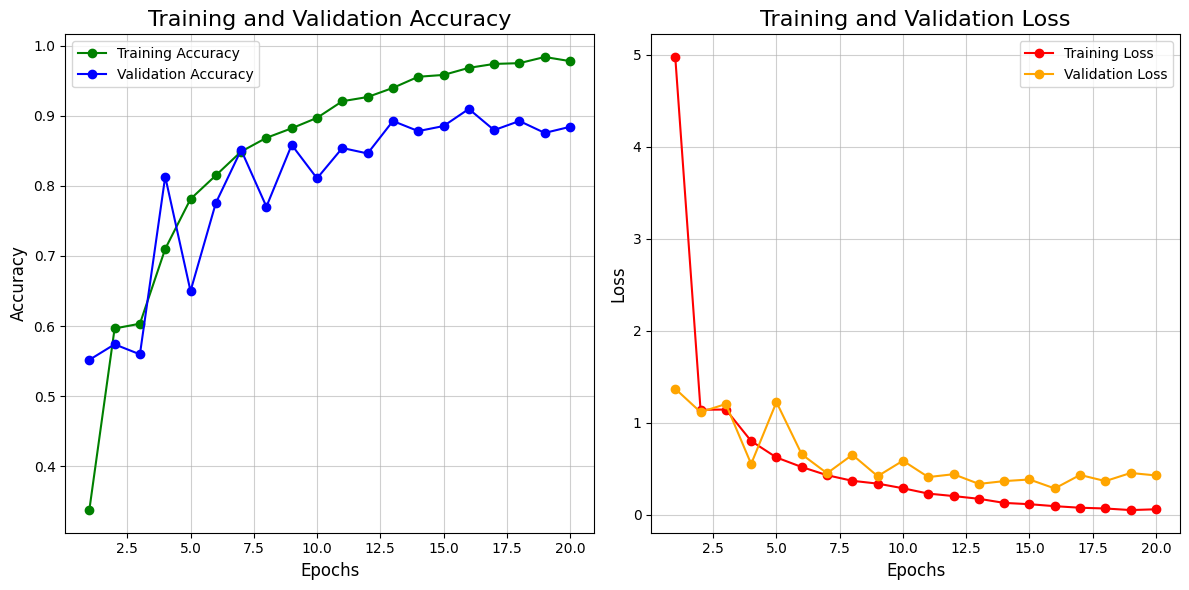

In [ ]:
import matplotlib.pyplot as plt

# Extract data for accuracy and loss
epochs = range(1, len(history_scenario_5.history['accuracy']) + 1)
train_acc = history_scenario_5.history['accuracy']
val_acc = history_scenario_5.history['val_accuracy']
train_loss = history_scenario_5.history['loss']
val_loss = history_scenario_5.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', color='green')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='blue')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(alpha=0.6)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 822,    7,   74,   15,    2,   22,   36,    0,   76,   17],
       [   0, 1091,    3,    0,    0,    0,    0,    0,    0,    0],
       [   0,   47,  990,    0,    4,    2,   14,   14,    4,    0],
       [   0,    0,   10,  827,   20,    0,    2,   12,    9,    0],
       [   0,    0,   12,    2,  854,    0,    0,   18,    2,    0],
       [   2,  116,   63,    4,    0,  469,   10,    9,   37,    6],
       [  12,    2,  226,   12,    9,    2,  592,   17,   14,    0],
       [   0,    2,    7,    0,   32,    0,    0, 1029,    0,    0],
       [   5,   12,   66,   24,    4,    4,    6,    2,  762,    4],
       [   0,   48,    6,    0,    0,    0,    0,    0,    4,  997]])

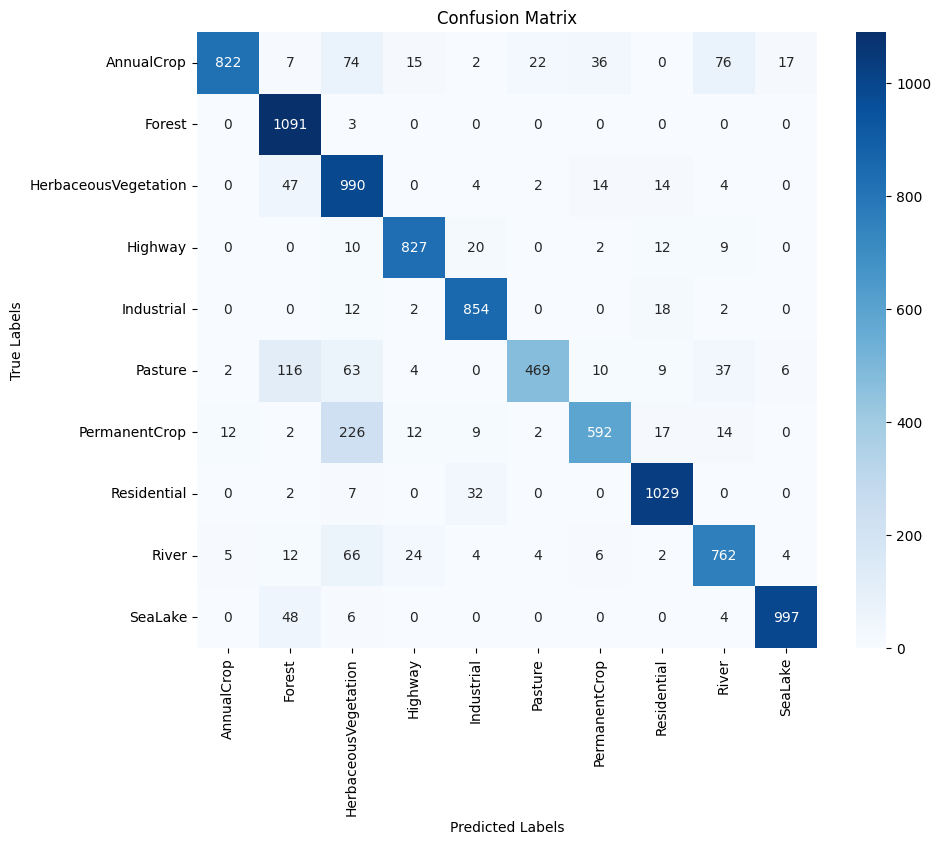

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels, predicted_labels, target_names=class_names))


                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.77      0.86      1071
              Forest       0.82      1.00      0.90      1094
HerbaceousVegetation       0.68      0.92      0.78      1075
             Highway       0.94      0.94      0.94       880
          Industrial       0.92      0.96      0.94       888
             Pasture       0.94      0.66      0.77       716
       PermanentCrop       0.90      0.67      0.77       886
         Residential       0.93      0.96      0.95      1070
               River       0.84      0.86      0.85       889
             SeaLake       0.97      0.95      0.96      1055

            accuracy                           0.88      9624
           macro avg       0.89      0.87      0.87      9624
        weighted avg       0.89      0.88      0.88      9624



In [ ]:
batch_size = 32
model = ResNet50(input_shape=(224, 224, 3), classes=10)
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_scenario_4 = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[checkpoint_callback],
    verbose=1
)